## Code to Compare ECMWF and Met Office Wind Data

The data in question is a small subset of the 10m wind available; we are exploring the behaviour seen around the AGAGE data collection site on the west coast of Ireland (Mace Head) in January-June 2015.

In [2]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import numpy as np

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'meteorological_data'

In [3]:
# MHD latitude and longitude - 53.3267° N, 9.9046° W
site_latitude = 53.3267
site_longitude = -9.9046

### Extracting Data

#### ECMWF

In [4]:
# extracting ECMWF data (covering area around MHD)
ecmwf_ds = xr.open_mfdataset((data_path/'ECMWF'/'MHD'/'10m_wind').glob('*.nc'))
ecmwf_df = ecmwf_ds.to_dataframe()

# interpolating data to as close to MHD as possible
interpolated_data = ecmwf_df.interpolate(method='linear', limit_direction='both', limit_area='inside')

tolerance = 0.1

# extracting u and v components of wind for MHD
ecmwf_mhd = interpolated_data[
    (interpolated_data.index.get_level_values('latitude') >= site_latitude - tolerance) &
    (interpolated_data.index.get_level_values('latitude') <= site_latitude + tolerance) &
    (interpolated_data.index.get_level_values('longitude') >= site_longitude - tolerance) &
    (interpolated_data.index.get_level_values('longitude') <= site_longitude + tolerance)
]

print(f"Interpolated Latitude = {ecmwf_mhd.index.get_level_values('latitude').values[0]}")
print(f"Interpolated Longitude = {ecmwf_mhd.index.get_level_values('longitude').values[0]}")

# dropping latitude and longitude index levels, not needed now narrowed down to only MHD
met_mhd = ecmwf_mhd.droplevel(['latitude', 'longitude'])

# resampling for 6 hourly readings, allows for easier comparison of datasets
resampled_ecmwf_mhd = met_mhd.resample('6H').mean()

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Interpolated Latitude = 53.25
Interpolated Longitude = -10.0


In [5]:
# filtering for just January data
jan_ecmwf_mhd = resampled_ecmwf_mhd['2015-01-01':'2015-01-31']

# calculating wind speed and direction from u and v components - January
jan_ecmwf_u = jan_ecmwf_mhd['u10']
jan_ecmwf_v = jan_ecmwf_mhd['v10']

jan_ecmwf_wind_speed = np.sqrt(jan_ecmwf_u**2 + jan_ecmwf_v**2)
jan_ecmwf_wind_direction = (np.arctan2(jan_ecmwf_u, jan_ecmwf_v) * 180 / np.pi) + 180

#### Met Office Data

In [6]:
# extracting Met Office data for January-June 2015
met_ds = xr.open_mfdataset((data_path/"MetOffice").glob("*01.nc"))

# dropping variables that are not needed
variables_to_drop = ['Temperature', 'PBLH', 'Pressure', 'Sea_level_pressure']
met_ds = met_ds.drop_vars(variables_to_drop)

met_df = met_ds.to_dataframe()

# interpolating data to as close to MHD as possible using same method as above
interpolated_data = met_df.interpolate(method='linear', limit_direction='both', limit_area='inside')

tolerance = 0.1

met_mhd = interpolated_data[
    (interpolated_data.index.get_level_values('lat') >= site_latitude - tolerance) &
    (interpolated_data.index.get_level_values('lat') <= site_latitude + tolerance) &
    (interpolated_data.index.get_level_values('lon') >= site_longitude - tolerance) &
    (interpolated_data.index.get_level_values('lon') <= site_longitude + tolerance)
]

print(f"Interpolated Latitude = {met_mhd.index.get_level_values('lat').values[0]}")
print(f"Interpolated Longitude = {met_mhd.index.get_level_values('lon').values[0]}")

met_mhd = met_mhd.droplevel(['lat', 'lon'])

resampled_met_mhd = met_mhd.resample('6H').mean()

Interpolated Latitude = 53.317
Interpolated Longitude = -9.900002


### January 2015

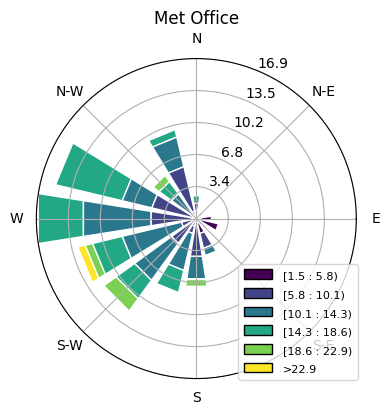

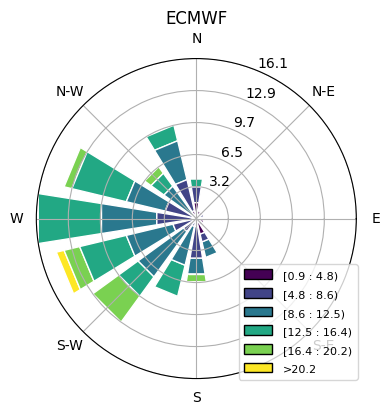

In [7]:
# Windrose plots
fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(resampled_met_mhd["Wind_Direction"], resampled_met_mhd["Wind_Speed"], 
       normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
ax.set_title("Met Office")
plt.show()

fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(jan_ecmwf_wind_direction, jan_ecmwf_wind_speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc=4)
ax.set_title("ECMWF")
plt.show()

Text(0.5, 0.98, 'Comparing ECMWF and Met Office Data, January 2015 at Mace Head, Ireland')

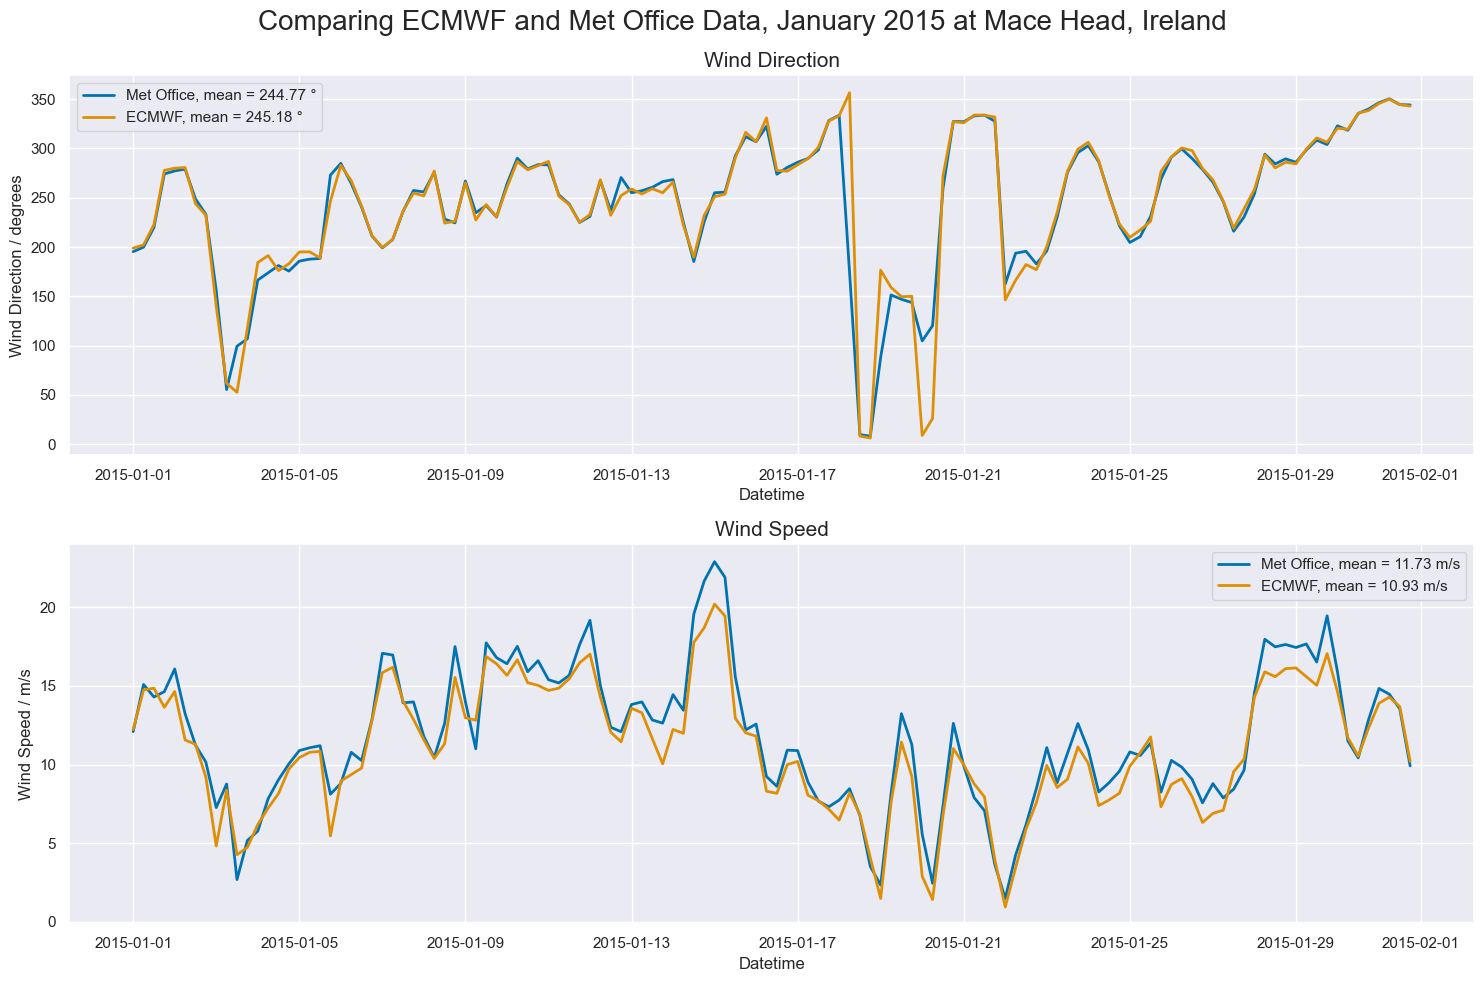

In [12]:
# plotting wind speeds and direction against time
fig, axs = plt.subplots(2,1, figsize=(15,10))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# plotting wind direction
axs[0].plot(resampled_met_mhd.index.get_level_values('time').values, resampled_met_mhd["Wind_Direction"].values,
           label=(f"Met Office, mean = {met_mhd['Wind_Direction'].values.mean():.2f} °"),
           linewidth=2)

axs[0].plot(jan_ecmwf_wind_direction.index.values, jan_ecmwf_wind_direction,
           label=(f"ECMWF, mean = {jan_ecmwf_wind_direction.mean():.2f} °"),
           linewidth=2)

axs[0].set_xlabel("Datetime")
axs[0].set_ylabel("Wind Direction / degrees")
axs[0].legend()
axs[0].set_title("Wind Direction", fontsize=15)

# plotting wind speed
axs[1].plot(resampled_met_mhd.index.get_level_values('time').values, resampled_met_mhd["Wind_Speed"].values,
           label=(f"Met Office, mean = {met_mhd['Wind_Speed'].values.mean():.2f} m/s"),
           linewidth=2)

axs[1].plot(jan_ecmwf_wind_speed.index.values, jan_ecmwf_wind_speed,
           label=(f"ECMWF, mean = {jan_ecmwf_wind_speed.mean():.2f} m/s"),
           linewidth=2)

axs[1].set_xlabel("Datetime")
axs[1].set_ylabel("Wind Speed / m/s")
axs[1].legend()
axs[1].set_title("Wind Speed", fontsize=15)

fig.set_tight_layout(True)
fig.suptitle("Comparing ECMWF and Met Office Data, January 2015 at Mace Head, Ireland", fontsize=20)

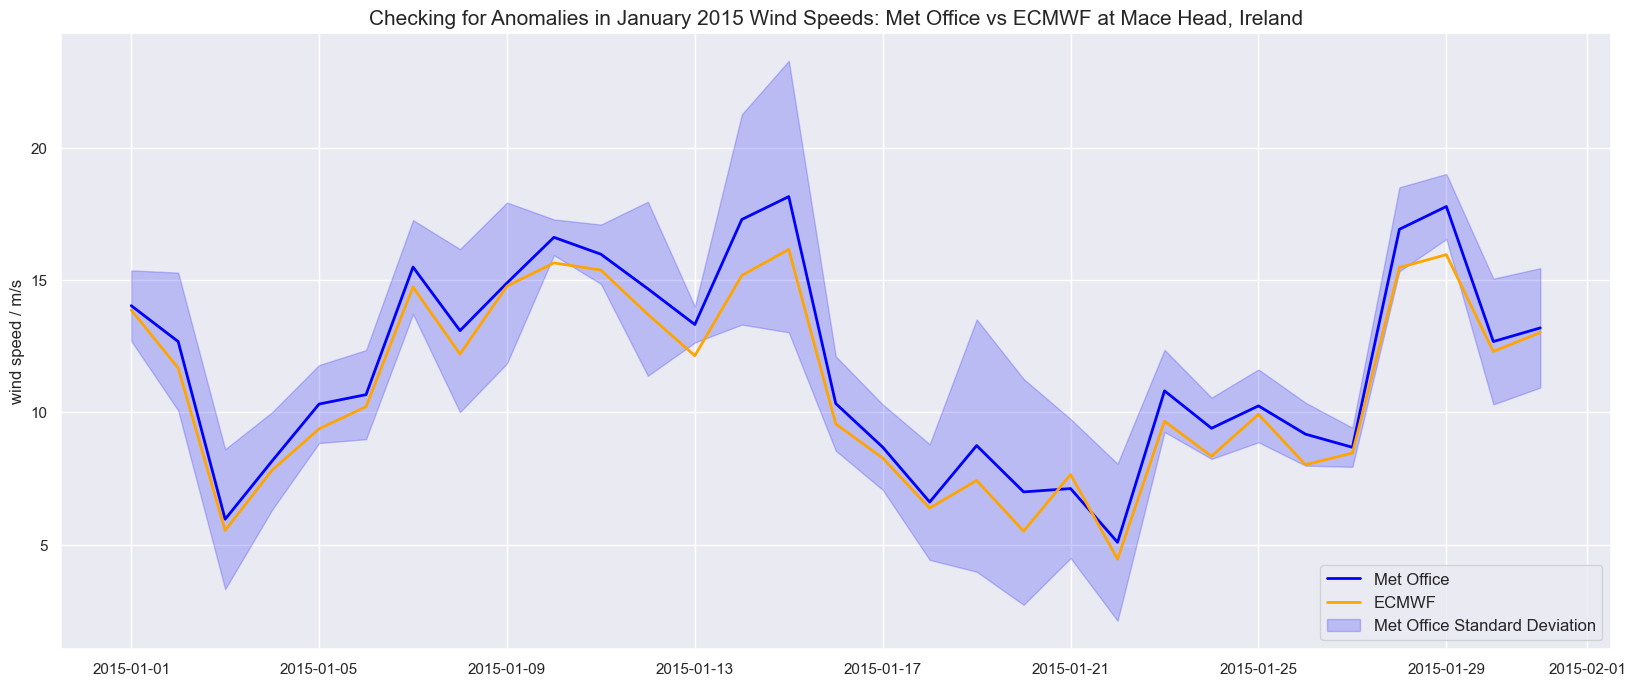

In [68]:
# Investing speed further - identifying anomalies
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# calculating daily averages
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)
met_daily.index = met_daily.index.to_timestamp()
ecmwf_daily = jan_ecmwf_wind_speed.groupby(jan_ecmwf_wind_speed.index.to_period('D')).mean().reset_index()
ecmwf_daily.set_index('time', inplace=True)

ax.plot(met_daily.index.get_level_values('time').values, met_daily["Wind_Speed"].values,
           label=(f"Met Office"), linewidth=2, color='blue')
ax.plot(ecmwf_daily.index.values, ecmwf_daily,
           label=(f"ECMWF"), linewidth=2, color='orange')

# calculating standard deviation
std_met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].std().reset_index()
std_met_daily.set_index('time', inplace=True)
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)


# adding standard deviation shading
upper_met = met_daily["Wind_Speed"] + std_met_daily["Wind_Speed"]
lower_met = met_daily["Wind_Speed"] - std_met_daily["Wind_Speed"]
ax.fill_between(met_daily.index, lower_met, upper_met, color='blue', alpha=0.2, label="Met Office Standard Deviation")


# adding tolerance range based on 3 standard deviations
upper_range = met_daily["Wind_Speed"] + 3*(std_met_daily['Wind_Speed'])
lower_range = met_daily["Wind_Speed"] - 3*(std_met_daily['Wind_Speed'])

# calculating overall std for arrows
overall_std = met_daily["Wind_Speed"].std()

# adding labels to points outside tolerance range
for i in range(len(met_daily)):
    if ecmwf_daily.loc[ecmwf_daily.index[i]].item() >= upper_range.loc[ecmwf_daily.index[i]]:
        arrow_end = ecmwf_daily.iloc[i] + (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%B %Y'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')

    elif ecmwf_daily.iloc[i].item() <= lower_range.iloc[i]:
        arrow_end = ecmwf_daily.iloc[i] - (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%B %Y'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

plt.ylabel("wind speed / m/s")
plt.title(f"Checking for Anomalies in January 2015 Wind Speeds: Met Office vs ECMWF at Mace Head, Ireland", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [29]:
# calculating and printing various descriptive statistics - WIND DIRECTION
met_mean = resampled_met_mhd['Wind_Direction'].values.mean()
ecmwf_mean = jan_ecmwf_wind_direction.mean()

met_median = np.median(resampled_met_mhd['Wind_Direction'].values)
ecmwf_median = np.median(jan_ecmwf_wind_direction)

met_std = np.std(resampled_met_mhd['Wind_Direction'].values)
ecmwf_std = np.std(jan_ecmwf_wind_direction)

met_range = resampled_met_mhd['Wind_Direction'].values.max() - resampled_met_mhd['Wind_Direction'].values.min()
ecmwf_range = jan_ecmwf_wind_direction.max() - jan_ecmwf_wind_direction.min()

print(f"Direction MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Direction MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Direction STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Direction RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Direction MEAN: Met Office = 244.767, ECMWF = 245.176
Direction MEDIAN: Met Office = 256.515, ECMWF = 254.292
Direction STANDARD DEVIATION: Met Office = 67.024, ECMWF = 71.114
Direction RANGE: Met Office = 342.122, ECMWF = 350.279


In [19]:
# calculating and printing various descriptive statistics - WIND SPEED
met_mean = resampled_met_mhd['Wind_Speed'].values.mean()
ecmwf_mean = jan_ecmwf_wind_speed.mean()

met_median = np.median(resampled_met_mhd['Wind_Speed'].values)
ecmwf_median = np.median(jan_ecmwf_wind_speed)

met_std = np.std(resampled_met_mhd['Wind_Speed'].values)
ecmwf_std = np.std(jan_ecmwf_wind_speed)

met_range = resampled_met_mhd['Wind_Speed'].values.max() - resampled_met_mhd['Wind_Speed'].values.min()
ecmwf_range = jan_ecmwf_wind_speed.max() - jan_ecmwf_wind_speed.min()

print(f"Speed MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Speed MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Speed STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Speed RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Speed MEAN: Met Office = 11.734, ECMWF = 10.931
Speed MEDIAN: Met Office = 11.215, ECMWF = 10.808
Speed STANDARD DEVIATION: Met Office = 4.300, ECMWF = 3.989
Speed RANGE: Met Office = 21.421, ECMWF = 19.269


### January - June 2015